**Authors:**

Daniel Vila de la Cruz

Sara Gómez Feás


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from keras.layers import LSTM, Dense, SimpleRNN

# 1. Introduction

The aim of this project is to develop different recurrent neural networks to solve a prediction problem for time series. For doing so, we are going to use the Walmart Sales Dataset of 45 stores (Kaggle dataset). Specifically, the problem consist on predict the weakly sales in 3 weeks, so it is a regression problem, and the metric to evaluate the results will be the MAE.

# 2. Prepare dataset

In [ ]:
#Returns a numpy array with size nrows x ncolumns-1. nrows and ncolums are the rows and columns of the dataset
#the Date column is skipped (ncolumns-1)
def readData(fname):
    with open(fname) as f:
        fileData = f.read()

    lines = fileData.split("\n")
    header = lines[0].split(",")
    lines = lines[1:]
    #print(header)
    #print("Data rows: ", len(lines))

    rawData = np.zeros((len(lines), len(header)-1)) #skip the Date column

    for i, aLine in enumerate(lines):
        splittedLine = aLine.split(",")[:]
        rawData[i, 0] = splittedLine[0]
        rawData[i, 1:] = [float(x) for x in splittedLine[2:]]

    return rawData

In [ ]:
#Returns the train and test data, normalized. It also returns the standard deviation of Weekly_Sales
#Each list has a size equal to the number of stores
#For each store there is a list of size trainNSaples (testNSamples) x nColums-1 (the store id is skipped)
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
def splitTrainTest(rawData, testPercent):

    listStore = np.unique(rawData[:, 0])
    trainNSamples = np.zeros(len(listStore))

    for i, storeId in enumerate(listStore):
        trainNSamples[i] = np.count_nonzero(rawData[:, 0] == storeId)
    trainNSamples = np.floor((1-testPercent) *  trainNSamples)

    tmpTrain = np.zeros((int(np.sum(trainNSamples)), len(rawData[0])))

    store = -1
    counter = 0
    counterTrain = 0
    storeDict = dict(zip(listStore, trainNSamples))
    for i, aLine in enumerate(rawData):
        if store != aLine[0]:
            store = int(aLine[0])
            counter = 0
        if(counter < storeDict.get(store)):
            tmpTrain[counterTrain] = rawData[i][:]
            counterTrain += 1
            counter += 1

    meanData = tmpTrain.mean(axis=0)
    stdData = tmpTrain.std(axis=0)
    rawNormData = (rawData - meanData) / stdData

    allTrain = list()
    allTest = list()
    store = -1
    counter = 0
    for i, aLine in enumerate(rawNormData):
        splittedLine = [float(x) for x in aLine[1:]] #skip store id
        if store != rawData[i][0]:
            if i != 0:
                allTrain.append(storeDataTrain)
                allTest.append(storeDataTest)
            store = int(rawData[i][0])
            storeDataTrain = list()
            storeDataTest = list()
            counter = 0

        if(counter < storeDict.get(store)):
            storeDataTrain.append(splittedLine)
            counter += 1
        else:
            storeDataTest.append(splittedLine)

        if i == len(rawNormData)-1:
            allTrain.append(storeDataTrain)
            allTest.append(storeDataTest)

    return allTrain, allTest, stdData[1] #std of wSales

In [ ]:
#generates a time series given the input and ouput data, the sequence length and the batch size
#seqLength is the number of weeks (observations) of data to be used as input
#the target will be the weekly sales in 2 weeks
def generateTimeSeries(data, wSales, seqLength, batchSize):
    sampling_rate = 1 #keep all the data points
    weeksInAdvance = 3
    delay = sampling_rate * (seqLength + weeksInAdvance - 1) #the target will be the weekly sales in 2 weeks

    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=wSales[delay:],
        sampling_rate=sampling_rate,
        sequence_length=seqLength,
        shuffle=True,
        batch_size=batchSize,
        start_index=0)

    return dataset

In [ ]:
def printTimeSeriesList(theList):
    print('list length', len(theList))
    print('First element')
    input, target = theList[0]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])
    print('Last element')
    input, target = theList[-1]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])

In [ ]:
#returns the training and test time series
#it also returns the standard deviation of Weekly_Sales, and the number of input features
def generateTrainTestData(fileName, testPercent, seqLength, batchSize):
    rawData = readData(os.path.join(fileName))
    allTrain, allTest, stdSales = splitTrainTest(rawData, testPercent)

    for i in range(len(allTrain)):
        tmp_train = generateTimeSeries(np.array(allTrain[i]), np.array(allTrain[i])[:,0], seqLength, batchSize)
        tmp_test = generateTimeSeries(np.array(allTest[i]), np.array(allTest[i])[:,0], seqLength, batchSize)

        if i == 0:
            train_dataset = tmp_train
            test_dataset = tmp_test
        else:
            train_dataset = train_dataset.concatenate(tmp_train)
            test_dataset = test_dataset.concatenate(tmp_test)

    return train_dataset, test_dataset, stdSales, np.shape(allTrain)[2]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#generateTrainTestData(fileName, testPercent, seqLength, batchSize):
#trainData, testData: each element comes from keras.utils.timeseries_dataset_from_array, i.e., is a time series
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
#Output feature: weakly sales in 3 weeks.

#path = "/content/drive/MyDrive/walmart-sales-dataset-of-45stores.csv"
path = "/content/drive/MyDrive/DL/P2 - RNN/walmart-sales-dataset-of-45stores.csv"

# trainData shape=(None, None, 6)
# nFeatures = 6
# seqLength can be changed


testPercent = 0.2
seqLength = 12
batchSize = 1
trainData, testData, stdSales, nFeatures = generateTrainTestData(path,
    testPercent, seqLength, batchSize)

# 3. Model


## 3.1 Simple models

First, we decided to try three simple models, in order to see how the diferent architectures (SimpleRNN, LSTM and GRU) perform on this problem. But before starting we though that GRU would be the most suited one, as it has been proved to have a similar performance that LSTM, but as the dataset we are using is not that big, GRU would perform a bit better.




### 3.1.1 Model examples

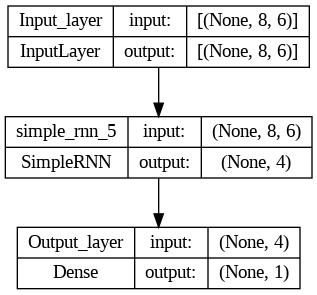

In [ ]:
inputs = keras.Input(shape=([8, 6]), name="Input_layer")
x = layers.SimpleRNN(4)(inputs)
outputs = layers.Dense(1, activation="linear", name="Output_layer")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="SimpleRNN")
tf.keras.utils.plot_model(model, show_shapes=True)

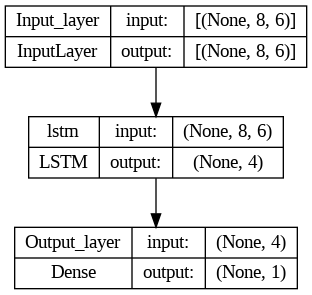

In [ ]:
inputs = keras.Input(shape=([8, 6]), name="Input_layer")
x = layers.LSTM(4)(inputs)
outputs = layers.Dense(1, activation="linear", name="Output_layer")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM")
tf.keras.utils.plot_model(model, show_shapes=True)

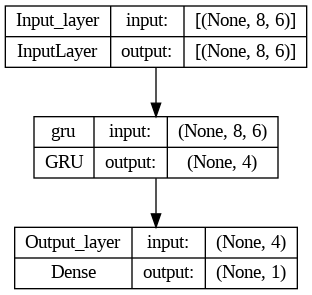

In [ ]:
inputs = keras.Input(shape=([8, 6]), name="Input_layer")
x = layers.GRU(4)(inputs)
outputs = layers.Dense(1, activation="linear", name="Output_layer")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="GRU")
tf.keras.utils.plot_model(model, show_shapes=True)

## 3.2 More complex models

This first approach showed that the three models were performing pretty similar, being GRU and LSTM a bit ahead of SimpleRNN.

The next step was to trying to improve the model. For doing so, we develop several options. We tried adding an additional Dense layer, mixing RNN layers, using bidirectional RNN layers, and using CNN before RNN.

### 3.2.1 Model examples

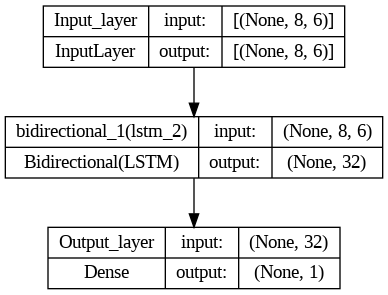

In [ ]:
inputs = keras.Input(shape=([8, 6]), name="Input_layer")

x = layers.Bidirectional(LSTM(16))(inputs)
outputs = layers.Dense(1, activation="linear", name="Output_layer")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="BI_LSTM")

tf.keras.utils.plot_model(model, show_shapes=True)

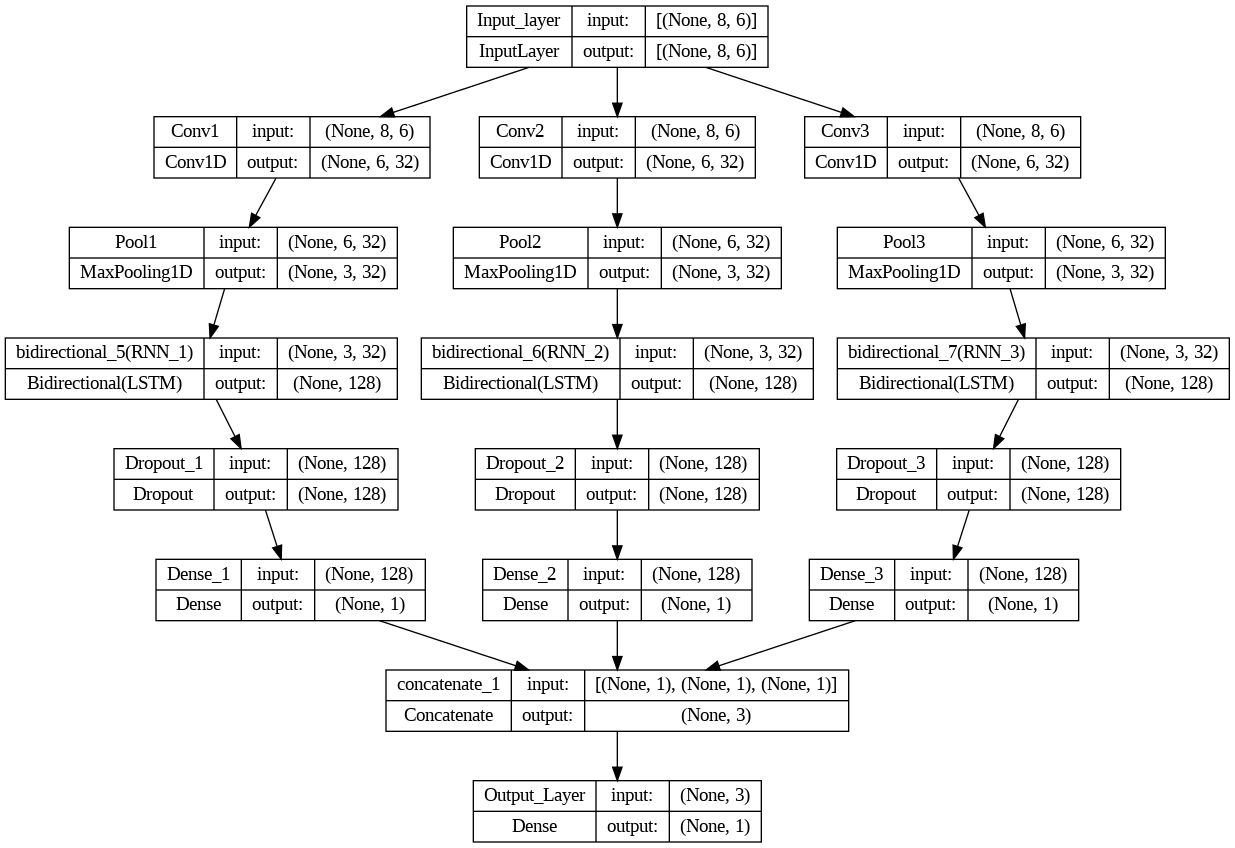

In [ ]:
x1 = layers.Conv1D(filters=32, kernel_size=3, activation="relu", name="Conv1")(inputs)
x1 = layers.MaxPooling1D(pool_size=2, name="Pool1")(x1)
x1 = layers.Bidirectional(layers.LSTM(64, return_sequences=False, name = "RNN_1"))(x1)
x1 = layers.Dropout(0.2, name = "Dropout_1")(x1)
x1 = layers.Dense(1, activation = 'linear', name = "Dense_1")(x1)

x2 = layers.Conv1D(filters=32, kernel_size=3, activation="relu", name="Conv2")(inputs)
x2 = layers.MaxPooling1D(pool_size=2, name="Pool2")(x2)
x2 = layers.Bidirectional(layers.LSTM(64, return_sequences=False, name = "RNN_2"))(x2)
x2 = layers.Dropout(0.2, name = "Dropout_2")(x2)
x2 = layers.Dense(1, activation = 'linear', name = "Dense_2")(x2)

x3 = layers.Conv1D(filters=32, kernel_size=3, activation="relu", name="Conv3")(inputs)
x3 = layers.MaxPooling1D(pool_size=2, name="Pool3")(x3)
x3 = layers.Bidirectional(layers.LSTM(64, return_sequences=False, name = "RNN_3"))(x3)
x3 = layers.Dropout(0.2, name = "Dropout_3")(x3)
x3 = layers.Dense(1, activation = 'linear', name = "Dense_3")(x3)

concatenated = layers.concatenate([x1, x2, x3])
outputs= layers.Dense(1, activation = 'linear', name = "Output_Layer")(concatenated)
model = keras.Model(inputs, outputs, name="CNN_LSTM")


tf.keras.utils.plot_model(model, show_shapes=True)

## 3.3 Best Models

All of those ideas to make the network more complex ended up giving worse results, so we decided to keep the network simple, and to increase the sequence length. This lead to better results, and now we had to explore some ways to regularize the model, in order to avoid overfitting but preserving the performance.

**Model A**

> We also noticed that with the same architecture some models performed way better than others, just because on the first iterations they achieve a better weighting. In order to avoid this and get better results on all models, we decided to reduce the learning rate. As the model were learning slower, we decided to increase the number of epochs. This could result in overfitting the network, so we also implemented an early stop.

**Model B**
> We wanted to explore more regularization techniques, but we find that we were decreasing the performance by a lot, so we decided to increase the complexity of the model, adding a second GRU layer, and using a small value for a recurrent dropout.








### 3.3.1 Model A

In [ ]:
inputs = keras.Input(shape=([12, 6]), name="Input_layer")

x = layers.GRU(256, name="GRU")(inputs)
outputs = layers.Dense(1, activation="linear", name="Output_layer")(x)
model_256 = keras.Model(inputs=inputs, outputs=outputs, name="GRU_256")

model_256.summary()

Model: "GRU_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 12, 6)]           0         
                                                                 
 GRU (GRU)                   (None, 256)               202752    
                                                                 
 Output_layer (Dense)        (None, 1)                 257       
                                                                 
Total params: 203,009
Trainable params: 203,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(lr=0.0003)
model_256.compile(optimizer=opt, loss="mean_squared_error", metrics=["mean_absolute_error"], weighted_metrics=[])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

history_256 = model_256.fit(trainData, epochs=100, validation_data=(testData), callbacks=[early_stop])

Epoch 1/100
4005/4005 [==============================] - 23s 5ms/step - loss: 0.0962 - mean_absolute_error: 0.1934 - val_loss: 0.0904 - val_mean_absolute_error: 0.2260
Epoch 2/100
4005/4005 [==============================] - 21s 5ms/step - loss: 0.0476 - mean_absolute_error: 0.1419 - val_loss: 0.0763 - val_mean_absolute_error: 0.1838
Epoch 3/100
4005/4005 [==============================] - 20s 5ms/step - loss: 0.0401 - mean_absolute_error: 0.1330 - val_loss: 0.0401 - val_mean_absolute_error: 0.1320
Epoch 4/100
4005/4005 [==============================] - 21s 5ms/step - loss: 0.0372 - mean_absolute_error: 0.1271 - val_loss: 0.0340 - val_mean_absolute_error: 0.1183
Epoch 5/100
4005/4005 [==============================] - 19s 5ms/step - loss: 0.0327 - mean_absolute_error: 0.1208 - val_loss: 0.0380 - val_mean_absolute_error: 0.1218
Epoch 6/100
4005/4005 [==============================] - 21s 5ms/step - loss: 0.0271 - mean_absolute_error: 0.1114 - val_loss: 0.0448 - val_mean_absolute_error:

In [ ]:
min(history_256.history['val_mean_absolute_error']) * stdSales

53136.1015872636

In [ ]:
h_eval = model_256.evaluate(testData)
h_eval[1] * stdSales

180/180 [==============================] - 2s 12ms/step - loss: 0.0189 - mean_absolute_error: 0.0929


53136.08880531321

### 3.3.1 Model B

In [ ]:
inputs = keras.Input(shape=([12, 6]), name="Input_layer")
x = layers.GRU(256, recurrent_dropout=0.2, return_sequences=True, name="GRU_1")(inputs)
x = layers.GRU(256, name="GRU_2")(x)
outputs = layers.Dense(1, activation="linear", name="Output_layer")(x)
model_256_2_drop = keras.Model(inputs=inputs, outputs=outputs, name="GRU_256_drop")

model_256_2_drop.summary()

Model: "GRU_256_drop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 12, 6)]           0         
                                                                 
 GRU_1 (GRU)                 (None, 12, 256)           202752    
                                                                 
 GRU_2 (GRU)                 (None, 256)               394752    
                                                                 
 Output_layer (Dense)        (None, 1)                 257       
                                                                 
Total params: 597,761
Trainable params: 597,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(lr=0.0003)
model_256_2_drop.compile(optimizer=opt, loss="mean_squared_error", metrics=["mean_absolute_error"], weighted_metrics=[])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

history_256_2_drop = model_256_2_drop.fit(trainData, epochs=100, validation_data=(testData), callbacks=[early_stop])

Epoch 1/100
4005/4005 [==============================] - 194s 47ms/step - loss: 0.1022 - mean_absolute_error: 0.1996 - val_loss: 0.1002 - val_mean_absolute_error: 0.2289
Epoch 2/100
4005/4005 [==============================] - 188s 47ms/step - loss: 0.0615 - mean_absolute_error: 0.1620 - val_loss: 0.0492 - val_mean_absolute_error: 0.1438
Epoch 3/100
4005/4005 [==============================] - 187s 47ms/step - loss: 0.0536 - mean_absolute_error: 0.1557 - val_loss: 0.0674 - val_mean_absolute_error: 0.1662
Epoch 4/100
4005/4005 [==============================] - 183s 46ms/step - loss: 0.0494 - mean_absolute_error: 0.1494 - val_loss: 0.0647 - val_mean_absolute_error: 0.1658
Epoch 5/100
4005/4005 [==============================] - 179s 45ms/step - loss: 0.0438 - mean_absolute_error: 0.1392 - val_loss: 0.0568 - val_mean_absolute_error: 0.1728
Epoch 6/100
4005/4005 [==============================] - 177s 44ms/step - loss: 0.0401 - mean_absolute_error: 0.1362 - val_loss: 0.0640 - val_mean_abs

In [ ]:
min(history_256_2_drop.history['val_mean_absolute_error']) * stdSales

64310.32547147093

In [ ]:
h_eval = model_256_2_drop.evaluate(testData)
h_eval[1] * stdSales

180/180 [==============================] - 2s 9ms/step - loss: 0.0260 - mean_absolute_error: 0.1190


68034.7813026481

# 4. Results

We can conclude that for this problem a low complexity network is what worked better. One possible explanation for this could be that the dataset used was relatively small in size, so a complex network wouldn't have enough data to work with.

Regarding the models, LSTM and GRU performed similarly. However, GRU offered slightly better results, while also requiring less computational time. These findings suggest that GRU may be a more efficient and effective option for this particular prediction problem, so our initial thoughts were correct.


Regarding the MAE, we were given an approximate target of 68000, and both proposed models were able to fullfit it. Thanks to early stopping we were able to avoid overfitting without risking that much performance. However, Model B requires way more time to train, and offers worse results that Model A. It should also be noted that Model B continues depending on the early stages of the training, and with the exact same model a MAE of 58028.49535298069 was obtained. Looking at the graphs, both are pretty similar, being the one corresponding to Model B more inconsistent, as it presents more abrupt changes.



In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

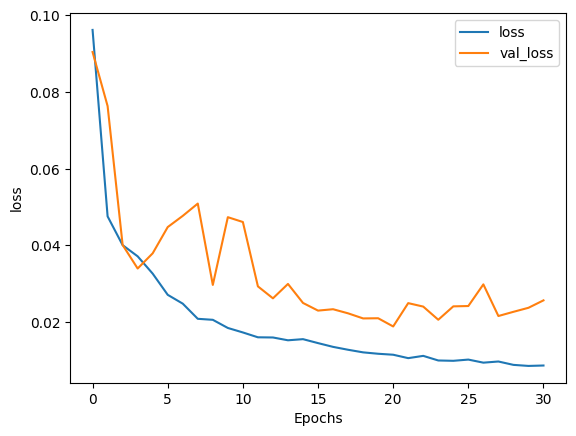

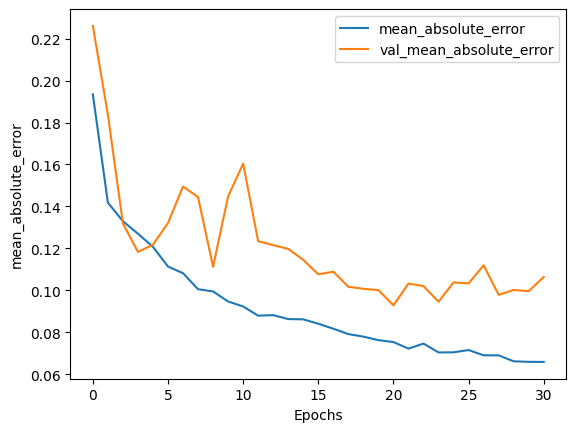

In [ ]:
plot_graphs(history_256, 'loss')
plt.show()
plot_graphs(history_256, 'mean_absolute_error')
plt.show()

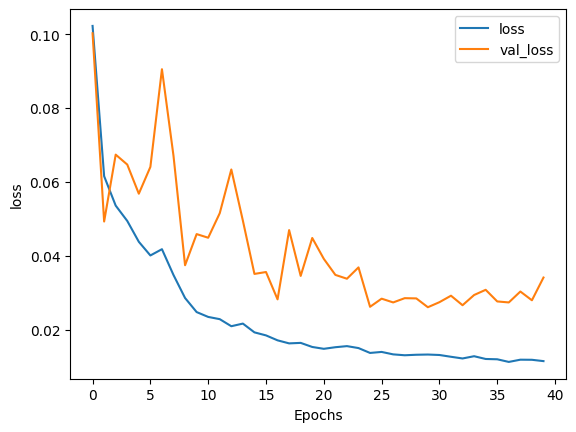

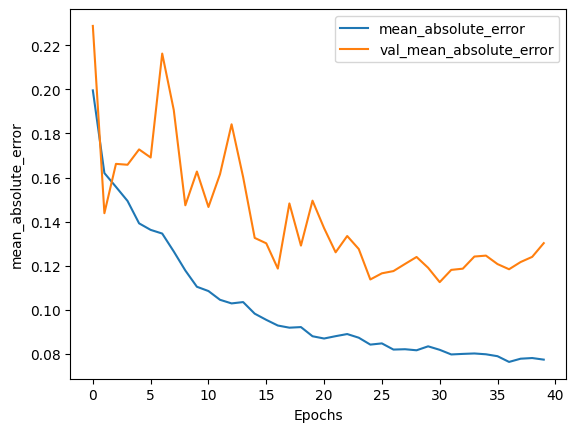

In [ ]:
plot_graphs(history_256_2_drop, 'loss')
plt.show()
plot_graphs(history_256_2_drop, 'mean_absolute_error')
plt.show()